In [1]:
# Basic data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import gc
import os
import re
import time
import pickle

# Machine learning
import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Directory paths - adjust these based on your current setup
# If you have directories defined somewhere in your code, we can use those variables
DATA_DIR = "/Users/braidosan/Downloads/home-credit-default-risk"  # Update this to your actual path

print("Setup Complete")

Setup Complete


In [3]:
def load_application_data():
    """Load main application data (train and test)"""
    print("Loading application data...")
    train_df = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))
    test_df = pd.read_csv(os.path.join(DATA_DIR, "application_test.csv"))
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    return train_df, test_df

def load_previous_applications():
    """Load previous applications data"""
    print("Loading previous applications...")
    prev_df = pd.read_csv(os.path.join(DATA_DIR, "previous_application.csv"))
    print(f"Previous applications shape: {prev_df.shape}")
    return prev_df

def load_bureau_data():
    """Load bureau data and bureau balance"""
    print("Loading bureau data...")
    bureau_df = pd.read_csv(os.path.join(DATA_DIR, "bureau.csv"))
    bureau_balance = pd.read_csv(os.path.join(DATA_DIR, "bureau_balance.csv"))
    print(f"Bureau shape: {bureau_df.shape}, Bureau balance shape: {bureau_balance.shape}")
    return bureau_df, bureau_balance

def load_installments():
    """Load installments payments data"""
    print("Loading installments...")
    installments = pd.read_csv(os.path.join(DATA_DIR, "installments_payments.csv"))
    print(f"Installments shape: {installments.shape}")
    return installments

def load_credit_card_balance():
    """Load credit card balance data"""
    print("Loading credit card balance...")
    cc_balance = pd.read_csv(os.path.join(DATA_DIR, "credit_card_balance.csv"))
    print(f"Credit card balance shape: {cc_balance.shape}")
    return cc_balance

def load_pos_cash():
    """Load POS cash balance data"""
    print("Loading POS cash balance...")
    pos_cash = pd.read_csv(os.path.join(DATA_DIR, "POS_CASH_balance.csv"))
    print(f"POS cash balance shape: {pos_cash.shape}")
    return pos_cash

In [5]:
# Load only what we need initially - main application and previous applications
train_df, test_df = load_application_data()
prev_df = load_previous_applications()

# We'll load other datasets when needed to manage memory
# bureau_df, bureau_balance = load_bureau_data()
# installments = load_installments()
# cc_balance = load_credit_card_balance()
# pos_cash = load_pos_cash()

Loading application data...
Train shape: (307511, 122), Test shape: (48744, 121)
Loading previous applications...
Previous applications shape: (1670214, 37)


In [9]:
def prepare_application_level_data():
    """
    Prepare data at the previous application level with TARGET from main application
    """
    print("Preparing application-level data...")
    
    # Get mapping from SK_ID_CURR to TARGET
    # We need this to add TARGET to each previous application
    target_mapping = train_df[['SK_ID_CURR', 'TARGET']].set_index('SK_ID_CURR')['TARGET'].to_dict()
    
    # Start with previous applications data
    prev_apps = prev_df.copy()
    
    # Filter to keep only applications from customers in the training set
    prev_apps = prev_apps[prev_apps['SK_ID_CURR'].isin(train_df['SK_ID_CURR'])]
    
    # Add TARGET to each previous application
    prev_apps['TARGET'] = prev_apps['SK_ID_CURR'].map(target_mapping)
    
    # Check for any missing targets (shouldn't be any if filtering worked correctly)
    missing_target = prev_apps['TARGET'].isnull().sum()
    if missing_target > 0:
        print(f"Warning: {missing_target} previous applications have missing TARGET values")
        # Drop rows with missing TARGET
        prev_apps = prev_apps.dropna(subset=['TARGET'])
    
    print(f"Application-level data ready: {prev_apps.shape}")
    
    # Display distribution of TARGET at application level
    target_dist = prev_apps['TARGET'].value_counts(normalize=True)
    print(f"TARGET distribution at application level:\n{target_dist}")
    
    return prev_apps

# Prepare application-level data
app_level_data = prepare_application_level_data()

# Display a sample of the data
print("\nSample of application-level data:")
print(app_level_data.sample(5)[['SK_ID_CURR', 'SK_ID_PREV', 'TARGET', 'AMT_CREDIT', 'DAYS_DECISION']].head())

Preparing application-level data...
Application-level data ready: (1413701, 38)
TARGET distribution at application level:
TARGET
0    0.913447
1    0.086553
Name: proportion, dtype: float64

Sample of application-level data:
         SK_ID_CURR  SK_ID_PREV  TARGET  AMT_CREDIT  DAYS_DECISION
395241       110288     2335913       0    225000.0           -478
1102737      119604     2029099       0   1338493.5           -589
744377       269213     1679002       0    241920.0           -300
132249       352173     2780315       1     86656.5           -253
1175071      215501     1598532       0     74182.5           -769


In [11]:
def preprocess_app_level_features(app_level_data):
    """
    Preprocess features for the application-level model
    """
    print("Preprocessing application-level features...")
    
    # Make a copy to avoid modifying the original
    df = app_level_data.copy()
    
    # Handle missing values
    for col in df.columns:
        # Skip ID columns and TARGET
        if col in ['SK_ID_CURR', 'SK_ID_PREV', 'TARGET']:
            continue
            
        # Fill categorical missing values with 'Missing'
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('Missing')
            
            # Label encode categorical columns
            lbe = LabelEncoder()
            df[col] = lbe.fit_transform(df[col])
        else:
            # Fill numerical missing values with median
            df[col] = df[col].fillna(df[col].median())
    
    # Create additional features from DAYS_DECISION
    df['DAYS_DECISION_ABS'] = np.abs(df['DAYS_DECISION'])  # Absolute value
    df['DAYS_DECISION_RECENT'] = np.exp(df['DAYS_DECISION'] / 100)  # Emphasize recent applications
    
    # Calculate some ratios that might be predictive
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'].replace(0, np.nan)
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'].replace(0, np.nan)
    df['DOWN_PAYMENT_TO_CREDIT'] = (df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']) / df['AMT_CREDIT'].replace(0, np.nan)
    
    # Fill NaN from division with 0
    df = df.fillna(0)
    
    # Check for any remaining missing values
    missing_values = df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: {missing_values} missing values remain after preprocessing")
    
    print(f"Preprocessing complete. Data shape: {df.shape}")
    return df

# Preprocess application-level features
app_level_features = preprocess_app_level_features(app_level_data)

# Display feature information
print("\nFeature information:")
print(f"Number of features: {app_level_features.shape[1] - 3}")  # Exclude SK_ID_CURR, SK_ID_PREV, TARGET

Preprocessing application-level features...
Preprocessing complete. Data shape: (1413701, 43)

Feature information:
Number of features: 40


In [13]:
def train_app_level_model(app_level_features, random_state=42):
    """
    Train the application-level model (Stage 1)
    """
    print("Training application-level model...")
    
    # Prepare features and target
    features = app_level_features.drop(['SK_ID_CURR', 'SK_ID_PREV', 'TARGET'], axis=1)
    target = app_level_features['TARGET']
    
    # Split data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, test_size=0.2, random_state=random_state, stratify=target
    )
    
    # Define the LightGBM model
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=random_state
    )
    
    # Train the model with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True)]
    )
    
    # Generate predictions for all applications
    all_predictions = model.predict_proba(features)[:, 1]
    
    # Add predictions back to the dataframe
    app_level_preds = app_level_features[['SK_ID_CURR', 'SK_ID_PREV']].copy()
    app_level_preds['APP_PRED'] = all_predictions
    
    # Show model performance
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"\nApplication-level model validation AUC: {val_auc:.4f}")
    
    # Show feature importance
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 important features:")
    print(feature_importance.head(20))
    
    return app_level_preds, model

# Train application-level model
app_level_preds, app_level_model = train_app_level_model(app_level_features)

Training application-level model...
[LightGBM] [Info] Number of positive: 97888, number of negative: 1033072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4512
[LightGBM] [Info] Number of data points in the train set: 1130960, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086553 -> initscore=-2.356468
[LightGBM] [Info] Start training from score -2.356468
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.630918	valid_0's binary_logloss: 0.285238

Application-level model validation AUC: 0.6309

Top 20 important features:
                       feature  importance
24            SELLERPLACE_AREA        2619
1                  AMT_ANNUITY        2300
15               DAYS_

In [15]:
def aggregate_app_predictions(app_level_preds):
    """
    Aggregate application-level predictions by customer
    """
    print("Aggregating application-level predictions by customer...")
    
    # Group by customer ID and calculate statistics of the predictions
    agg_preds = app_level_preds.groupby('SK_ID_CURR').agg({
        'APP_PRED': ['mean', 'max', 'min', 'std', 'count']
    })
    
    # Flatten column names
    agg_preds.columns = ['APP_PRED_' + col for col in ['MEAN', 'MAX', 'MIN', 'STD', 'COUNT']]
    
    # Reset index
    agg_preds = agg_preds.reset_index()
    
    # Handle missing std values (customers with only one application)
    agg_preds['APP_PRED_STD'] = agg_preds['APP_PRED_STD'].fillna(0)
    
    # Add range feature
    agg_preds['APP_PRED_RANGE'] = agg_preds['APP_PRED_MAX'] - agg_preds['APP_PRED_MIN']
    
    # Add normalized count (log transform to handle skewness)
    agg_preds['APP_PRED_COUNT_NORM'] = np.log1p(agg_preds['APP_PRED_COUNT'])
    
    print(f"Aggregated predictions shape: {agg_preds.shape}")
    
    # Display sample of aggregated predictions
    print("\nSample of aggregated predictions:")
    print(agg_preds.sample(5))
    
    return agg_preds

# Aggregate application-level predictions
agg_preds = aggregate_app_predictions(app_level_preds)

Aggregating application-level predictions by customer...
Aggregated predictions shape: (291057, 8)

Sample of aggregated predictions:
        SK_ID_CURR  APP_PRED_MEAN  APP_PRED_MAX  APP_PRED_MIN  APP_PRED_STD  \
231160      382531       0.083107      0.100546      0.050397      0.028349   
148045      281405       0.099963      0.099963      0.099963      0.000000   
35965       143951       0.055676      0.070629      0.041527      0.011905   
65802       180592       0.085423      0.085423      0.085423      0.000000   
71014       187014       0.072075      0.076678      0.067472      0.006510   

        APP_PRED_COUNT  APP_PRED_RANGE  APP_PRED_COUNT_NORM  
231160               3        0.050149             1.386294  
148045               1        0.000000             0.693147  
35965                4        0.029101             1.609438  
65802                1        0.000000             0.693147  
71014                2        0.009206             1.098612  


In [17]:
def prepare_main_model_data(train_df, test_df, agg_preds):
    """
    Prepare data for main customer-level model (Stage 2)
    """
    print("Preparing main model data with aggregated predictions...")
    
    # Add aggregated predictions to training data
    train_with_preds = train_df.merge(agg_preds, on='SK_ID_CURR', how='left')
    
    # Fill missing values for customers with no previous applications
    for col in ['APP_PRED_MEAN', 'APP_PRED_MAX', 'APP_PRED_MIN']:
        # For customers with no previous applications, use a default value
        # We could use the overall mean, but 0.5 is a reasonable default for a probability
        train_with_preds[col] = train_with_preds[col].fillna(0.5)
    
    train_with_preds['APP_PRED_STD'] = train_with_preds['APP_PRED_STD'].fillna(0)
    train_with_preds['APP_PRED_RANGE'] = train_with_preds['APP_PRED_RANGE'].fillna(0)
    train_with_preds['APP_PRED_COUNT'] = train_with_preds['APP_PRED_COUNT'].fillna(0)
    train_with_preds['APP_PRED_COUNT_NORM'] = train_with_preds['APP_PRED_COUNT_NORM'].fillna(0)
    
    # Check how many customers have previous applications
    has_prev_apps = train_with_preds['APP_PRED_COUNT'] > 0
    print(f"Customers with previous applications: {has_prev_apps.sum()} ({has_prev_apps.mean()*100:.2f}%)")
    
    # The test data won't have aggregated predictions yet since we haven't run the application model on it
    # We'll deal with this later
    
    print(f"Training data with predictions shape: {train_with_preds.shape}")
    
    return train_with_preds, test_df

# Prepare main model data
train_with_preds, test_df = prepare_main_model_data(train_df, test_df, agg_preds)

Preparing main model data with aggregated predictions...
Customers with previous applications: 291057 (94.65%)
Training data with predictions shape: (307511, 129)


In [19]:
def preprocess_main_data(df, is_training=True):
    """
    Preprocess the main dataset for model training
    """
    print(f"Preprocessing {'training' if is_training else 'test'} data...")
    
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Define columns to drop
    cols_to_drop = ['SK_ID_CURR']
    if is_training:
        # TARGET is not dropped from training data
        pass
    
    # Handle missing values in numerical columns
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        # Skip TARGET and identifier columns
        if col in ['TARGET', 'SK_ID_CURR']:
            continue
            
        # Replace infinity values with NaN
        data[col] = data[col].replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN with median
        data[col] = data[col].fillna(data[col].median())
    
    # Handle categorical columns
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        # Fill missing with 'Unknown'
        data[col] = data[col].fillna('Unknown')
        
        # Label encode categorical variables
        if col not in cols_to_drop:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    
    # Create some additional features
    
    # Age in years (negative because DAYS_BIRTH is negative)
    if 'DAYS_BIRTH' in data.columns:
        data['AGE_YEARS'] = -data['DAYS_BIRTH'] / 365
    
    # Credit to income ratio
    if 'AMT_CREDIT' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    
    # Annuity to income ratio
    if 'AMT_ANNUITY' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    
    # Fill any NaNs created by division
    for col in data.columns:
        if col not in cols_to_drop + ['TARGET']:
            data[col] = data[col].replace([np.inf, -np.inf], np.nan)
            data[col] = data[col].fillna(0)
    
    print(f"Preprocessing complete. Data shape: {data.shape}")
    return data

# Preprocess training data
train_processed = preprocess_main_data(train_with_preds, is_training=True)

Preprocessing training data...
Preprocessing complete. Data shape: (307511, 132)


In [21]:
def train_main_model_cv(train_data, n_splits=5, random_state=42):
    """
    Train the main model (Stage 2) with cross-validation
    """
    print("Training main model with cross-validation...")
    
    # Prepare features and target
    X = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = train_data['TARGET']
    
    # Initialize LightGBM classifier
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=random_state
    )
    
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Lists to store results
    cv_scores = []
    feature_importance_dfs = []
    oof_preds = np.zeros(len(X))
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model with early stopping
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True)]
        )
        
        # Predict on validation set
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        
        # Calculate AUC
        auc = roc_auc_score(y_val, val_preds)
        cv_scores.append(auc)
        print(f"Fold {fold + 1} AUC: {auc:.4f}")
        
        # Store feature importance
        fold_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        })
        fold_importance['fold'] = fold + 1
        feature_importance_dfs.append(fold_importance)
    
    # Calculate overall CV score
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f"\nCross-validation AUC: {cv_score_mean:.4f} ± {cv_score_std:.4f}")
    
    # Calculate overall AUC on out-of-fold predictions
    oof_auc = roc_auc_score(y, oof_preds)
    print(f"Out-of-fold AUC: {oof_auc:.4f}")
    
    # Combine feature importances from all folds
    feature_importance = pd.concat(feature_importance_dfs)
    feature_importance_mean = feature_importance.groupby('feature')['importance'].mean().reset_index()
    feature_importance_mean = feature_importance_mean.sort_values('importance', ascending=False)
    
    print("\nTop 20 important features:")
    print(feature_importance_mean.head(20))
    
    # Check the rank of our new application-level prediction features
    app_pred_features = [col for col in X.columns if col.startswith('APP_PRED_')]
    app_pred_importance = feature_importance_mean[feature_importance_mean['feature'].isin(app_pred_features)]
    print("\nRanking of application-level prediction features:")
    for i, row in app_pred_importance.iterrows():
        print(f"Rank {feature_importance_mean[feature_importance_mean['feature'] == row['feature']].index[0] + 1}: {row['feature']} - Importance: {row['importance']}")
    
    return model, feature_importance_mean, oof_preds, oof_auc

# Train main model with cross-validation
main_model, feature_importance, oof_preds, oof_auc = train_main_model_cv(train_processed)

Training main model with cross-validation...

Fold 1/5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13354
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's auc: 0.802885	valid_0's binary_logloss: 0.230665
Fold 1 AUC: 0.8029

Fold 2/5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062662 seconds.
You can set `for

In [23]:
def prepare_test_data():
    """
    Prepare test data with application-level predictions
    """
    print("Preparing test data with application-level predictions...")
    
    # Load previous applications for test customers
    test_prev_apps = prev_df[prev_df['SK_ID_CURR'].isin(test_df['SK_ID_CURR'])]
    print(f"Previous applications for test customers: {test_prev_apps.shape}")
    
    # Preprocess these applications (same as we did for training)
    test_prev_features = preprocess_app_level_features(test_prev_apps)
    
    # Use our application-level model to generate predictions
    X_test_prev = test_prev_features.drop(['SK_ID_CURR', 'SK_ID_PREV', 'TARGET'], axis=1, errors='ignore')
    
    # Make sure X_test_prev has the same columns as the training data
    missing_cols = set(app_level_model.feature_name_) - set(X_test_prev.columns)
    for col in missing_cols:
        X_test_prev[col] = 0  # Add missing columns with default values
    
    # Use only the columns that were used during training
    X_test_prev = X_test_prev[app_level_model.feature_name_]
    
    # Generate predictions
    test_prev_preds = app_level_model.predict_proba(X_test_prev)[:, 1]
    
    # Add predictions back to the dataframe
    test_app_preds = test_prev_features[['SK_ID_CURR', 'SK_ID_PREV']].copy()
    test_app_preds['APP_PRED'] = test_prev_preds
    
    # Aggregate predictions by customer
    test_agg_preds = aggregate_app_predictions(test_app_preds)
    
    # Add aggregated predictions to test data
    test_with_preds = test_df.merge(test_agg_preds, on='SK_ID_CURR', how='left')
    
    # Fill missing values for customers with no previous applications
    for col in ['APP_PRED_MEAN', 'APP_PRED_MAX', 'APP_PRED_MIN']:
        test_with_preds[col] = test_with_preds[col].fillna(0.5)
    
    test_with_preds['APP_PRED_STD'] = test_with_preds['APP_PRED_STD'].fillna(0)
    test_with_preds['APP_PRED_RANGE'] = test_with_preds['APP_PRED_RANGE'].fillna(0)
    test_with_preds['APP_PRED_COUNT'] = test_with_preds['APP_PRED_COUNT'].fillna(0)
    test_with_preds['APP_PRED_COUNT_NORM'] = test_with_preds['APP_PRED_COUNT_NORM'].fillna(0)
    
    # Preprocess the test data
    test_processed = preprocess_main_data(test_with_preds, is_training=False)
    
    return test_processed, test_with_preds['SK_ID_CURR']

# Prepare test data
test_processed, test_ids = prepare_test_data()

Preparing test data with application-level predictions...
Previous applications for test customers: (256513, 37)
Preprocessing application-level features...
Preprocessing complete. Data shape: (256513, 42)
Aggregating application-level predictions by customer...
Aggregated predictions shape: (47800, 8)

Sample of aggregated predictions:
       SK_ID_CURR  APP_PRED_MEAN  APP_PRED_MAX  APP_PRED_MIN  APP_PRED_STD  \
43317      422796       0.096354      0.106559      0.086150      0.014432   
16423      220949       0.069017      0.085832      0.042140      0.016536   
32066      338174       0.067087      0.170206      0.039867      0.034702   
14046      203176       0.081933      0.101858      0.070103      0.017356   
43936      428143       0.121032      0.192098      0.070576      0.046701   

       APP_PRED_COUNT  APP_PRED_RANGE  APP_PRED_COUNT_NORM  
43317               2        0.020409             1.098612  
16423               6        0.043692             1.945910  
32066    

In [25]:
def train_final_model_and_predict(train_data, test_data, test_ids):
    """
    Train a final model on all training data and make predictions on test data
    """
    print("Training final model and generating predictions...")
    
    # Prepare features and target
    X_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_train = train_data['TARGET']
    
    # Make sure test data has the same columns as training data
    missing_cols = set(X_train.columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0  # Add missing columns with default values
        
    # Use only the columns that exist in training data
    X_test = test_data[X_train.columns]
    
    # Initialize LightGBM classifier with the parameters that worked well in CV
    final_model = lgbm.LGBMClassifier(
        n_estimators=500,  # We'll use a fixed number based on the average from CV
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=42
    )
    
    # Train the model on all training data
    final_model.fit(X_train, y_train)
    
    # Generate predictions on test data
    test_preds = final_model.predict_proba(X_test)[:, 1]
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'SK_ID_CURR': test_ids,
        'TARGET': test_preds
    })
    
    # Save submission to CSV
    submission_path = os.path.join(DATA_DIR, "submission_two_stage.csv")
    submission.to_csv(submission_path, index=False)
    
    print(f"Submission saved to {submission_path}")
    print(f"Submission predictions range: {submission['TARGET'].min()} to {submission['TARGET'].max()}")
    
    return submission, final_model

# Train final model and generate predictions
submission, final_model = train_final_model_and_predict(train_processed, test_processed, test_ids)

Training final model and generating predictions...
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13448
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Submission saved to /Users/braidosan/Downloads/home-credit-default-risk/submission_two_stage.csv
Submission predictions range: 0.001133585423086148 to 0.8510268314150462


In [28]:
# At the end of your current notebook, save the current results
import pickle

# Create a results directory if it doesn't exist
results_dir = os.path.join(DATA_DIR, 'model_versions')
os.makedirs(results_dir, exist_ok=True)

# Save version information
version_info = {
    'version': 'two_stage_v1',
    'cv_auc': 0.8036,
    'cv_std': 0.0044,
    'feature_importance': feature_importance,
    'description': 'Two-stage model with application-level predictions'
}

# Save models and results
with open(os.path.join(results_dir, 'two_stage_v1_app_level_model.pkl'), 'wb') as f:
    pickle.dump(app_level_model, f)

with open(os.path.join(results_dir, 'two_stage_v1_final_model.pkl'), 'wb') as f:
    pickle.dump(final_model, f)
    
with open(os.path.join(results_dir, 'two_stage_v1_info.pkl'), 'wb') as f:
    pickle.dump(version_info, f)

# Save a copy of the submission with version number
submission.to_csv(os.path.join(results_dir, 'submission_two_stage_v1.csv'), index=False)

print("Model version 'two_stage_v1' saved successfully")

Model version 'two_stage_v1' saved successfully


In [30]:
# Load bureau data
print("Loading bureau data...")
bureau_df, bureau_balance = load_bureau_data()

Loading bureau data...
Loading bureau data...
Bureau shape: (1716428, 17), Bureau balance shape: (27299925, 3)


In [32]:
def prepare_bureau_level_data():
    """
    Prepare data at the bureau record level with TARGET from main application
    """
    print("Preparing bureau-level data...")
    
    # Get mapping from SK_ID_CURR to TARGET
    target_mapping = train_df[['SK_ID_CURR', 'TARGET']].set_index('SK_ID_CURR')['TARGET'].to_dict()
    
    # Start with bureau data
    bureau_data = bureau_df.copy()
    
    # Filter to keep only records from customers in the training set
    bureau_data = bureau_data[bureau_data['SK_ID_CURR'].isin(train_df['SK_ID_CURR'])]
    
    # Add TARGET to each bureau record
    bureau_data['TARGET'] = bureau_data['SK_ID_CURR'].map(target_mapping)
    
    # Check for any missing targets
    missing_target = bureau_data['TARGET'].isnull().sum()
    if missing_target > 0:
        print(f"Warning: {missing_target} bureau records have missing TARGET values")
        # Drop rows with missing TARGET
        bureau_data = bureau_data.dropna(subset=['TARGET'])
    
    print(f"Bureau-level data ready: {bureau_data.shape}")
    
    # Display distribution of TARGET at bureau level
    target_dist = bureau_data['TARGET'].value_counts(normalize=True)
    print(f"TARGET distribution at bureau level:\n{target_dist}")
    
    return bureau_data

# Prepare bureau-level data
bureau_level_data = prepare_bureau_level_data()

# Display a sample of the data
print("\nSample of bureau-level data:")
print(bureau_level_data.sample(5)[['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET', 'DAYS_CREDIT', 'AMT_CREDIT_SUM']].head())

Preparing bureau-level data...
Bureau-level data ready: (1465325, 18)
TARGET distribution at bureau level:
TARGET
0    0.921847
1    0.078153
Name: proportion, dtype: float64

Sample of bureau-level data:
         SK_ID_CURR  SK_ID_BUREAU  TARGET  DAYS_CREDIT  AMT_CREDIT_SUM
1437550      160066       5399728       0         -594       3015000.0
983321       432057       5073254       0        -2874         92700.0
1585205      230562       5583191       0         -182        135000.0
265532       438166       5890410       0        -1618        124519.5
565991       247996       5692855       0        -2626        202500.0


In [34]:
def preprocess_bureau_level_features(bureau_data):
    """
    Preprocess features for the bureau-level model
    """
    print("Preprocessing bureau-level features...")
    
    # Make a copy to avoid modifying the original
    df = bureau_data.copy()
    
    # Add aggregated bureau balance features if needed
    # This is optional but can add valuable information
    try:
        # Group bureau balance by SK_ID_BUREAU
        bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
            'MONTHS_BALANCE': ['min', 'max', 'mean', 'size'],
            'STATUS': lambda x: x.value_counts().get('C', 0)  # Count of 'C' (closed) statuses
        })
        
        # Flatten column names
        bureau_balance_agg.columns = ['BB_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]
        bureau_balance_agg = bureau_balance_agg.reset_index()
        
        # Merge with bureau data
        df = df.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')
        print("Added bureau balance features")
    except Exception as e:
        print(f"Error adding bureau balance features: {e}")
    
    # Handle missing values
    for col in df.columns:
        # Skip ID columns and TARGET
        if col in ['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET']:
            continue
            
        # Fill categorical missing values with 'Missing'
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('Missing')
            
            # Label encode categorical columns
            lbe = LabelEncoder()
            df[col] = lbe.fit_transform(df[col])
        else:
            # Fill numerical missing values with median
            df[col] = df[col].fillna(df[col].median())
    
    # Create additional features from DAYS_CREDIT
    df['DAYS_CREDIT_ABS'] = np.abs(df['DAYS_CREDIT'])  # Absolute value
    df['DAYS_CREDIT_RECENT'] = np.exp(df['DAYS_CREDIT'] / 365)  # Emphasize recent credits
    
    # Calculate credit utilization if possible
    if 'AMT_CREDIT_SUM' in df.columns and 'AMT_CREDIT_SUM_LIMIT' in df.columns:
        df['CREDIT_UTILIZATION'] = df['AMT_CREDIT_SUM'] / df['AMT_CREDIT_SUM_LIMIT'].replace(0, np.nan)
        df['CREDIT_UTILIZATION'] = df['CREDIT_UTILIZATION'].fillna(1)  # Assume 100% utilization when limit is 0
        df['CREDIT_UTILIZATION'] = df['CREDIT_UTILIZATION'].clip(0, 1)  # Clip between 0 and 1
    
    # Calculate overdue ratio if possible
    if 'AMT_CREDIT_SUM_OVERDUE' in df.columns and 'AMT_CREDIT_SUM' in df.columns:
        df['OVERDUE_RATIO'] = df['AMT_CREDIT_SUM_OVERDUE'] / df['AMT_CREDIT_SUM'].replace(0, np.nan)
        df['OVERDUE_RATIO'] = df['OVERDUE_RATIO'].fillna(0)
        df['OVERDUE_RATIO'] = df['OVERDUE_RATIO'].clip(0, 1)  # Clip between 0 and 1
    
    # Fill NaN from division with 0
    df = df.fillna(0)
    
    print(f"Preprocessing complete. Data shape: {df.shape}")
    return df

# Preprocess bureau-level features
bureau_level_features = preprocess_bureau_level_features(bureau_level_data)

# Display feature information
print("\nFeature information:")
print(f"Number of features: {bureau_level_features.shape[1] - 3}")  # Exclude SK_ID_CURR, SK_ID_BUREAU, TARGET

Preprocessing bureau-level features...
Added bureau balance features
Preprocessing complete. Data shape: (1465325, 27)

Feature information:
Number of features: 24


In [36]:
def train_bureau_level_model(bureau_level_features, random_state=42):
    """
    Train the bureau-level model (Stage 1 for bureau data)
    """
    print("Training bureau-level model...")
    
    # Prepare features and target
    features = bureau_level_features.drop(['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET'], axis=1)
    target = bureau_level_features['TARGET']
    
    # Split data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, test_size=0.2, random_state=random_state, stratify=target
    )
    
    # Define the LightGBM model
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=random_state
    )
    
    # Train the model with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True)]
    )
    
    # Generate predictions for all bureau records
    all_predictions = model.predict_proba(features)[:, 1]
    
    # Add predictions back to the dataframe
    bureau_level_preds = bureau_level_features[['SK_ID_CURR', 'SK_ID_BUREAU']].copy()
    bureau_level_preds['BUREAU_PRED'] = all_predictions
    
    # Show model performance
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"\nBureau-level model validation AUC: {val_auc:.4f}")
    
    # Show feature importance
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 important features:")
    print(feature_importance.head(20))
    
    return bureau_level_preds, model

# Train bureau-level model
bureau_level_preds, bureau_level_model = train_bureau_level_model(bureau_level_features)


Training bureau-level model...
[LightGBM] [Info] Number of positive: 91616, number of negative: 1080644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4087
[LightGBM] [Info] Number of data points in the train set: 1172260, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078153 -> initscore=-2.467707
[LightGBM] [Info] Start training from score -2.467707
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [38]:
def aggregate_bureau_predictions(bureau_level_preds):
    """
    Aggregate bureau-level predictions by customer
    """
    print("Aggregating bureau-level predictions by customer...")
    
    # Group by customer ID and calculate statistics of the predictions
    agg_preds = bureau_level_preds.groupby('SK_ID_CURR').agg({
        'BUREAU_PRED': ['mean', 'max', 'min', 'std', 'count']
    })
    
    # Flatten column names
    agg_preds.columns = ['BUREAU_PRED_' + col for col in ['MEAN', 'MAX', 'MIN', 'STD', 'COUNT']]
    
    # Reset index
    agg_preds = agg_preds.reset_index()
    
    # Handle missing std values (customers with only one bureau record)
    agg_preds['BUREAU_PRED_STD'] = agg_preds['BUREAU_PRED_STD'].fillna(0)
    
    # Add range feature
    agg_preds['BUREAU_PRED_RANGE'] = agg_preds['BUREAU_PRED_MAX'] - agg_preds['BUREAU_PRED_MIN']
    
    # Add normalized count (log transform to handle skewness)
    agg_preds['BUREAU_PRED_COUNT_NORM'] = np.log1p(agg_preds['BUREAU_PRED_COUNT'])
    
    print(f"Aggregated bureau predictions shape: {agg_preds.shape}")
    
    # Display sample of aggregated predictions
    print("\nSample of aggregated bureau predictions:")
    print(agg_preds.sample(5))
    
    return agg_preds

# Aggregate bureau-level predictions
bureau_agg_preds = aggregate_bureau_predictions(bureau_level_preds)

Aggregating bureau-level predictions by customer...
Aggregated bureau predictions shape: (263491, 8)

Sample of aggregated bureau predictions:
        SK_ID_CURR  BUREAU_PRED_MEAN  BUREAU_PRED_MAX  BUREAU_PRED_MIN  \
232660      414753          0.091543         0.091543         0.091543   
138390      287020          0.065243         0.072053         0.055617   
232518      414558          0.074000         0.097013         0.062533   
170807      331043          0.084672         0.088410         0.080934   
218851      395579          0.101481         0.123154         0.079807   

        BUREAU_PRED_STD  BUREAU_PRED_COUNT  BUREAU_PRED_RANGE  \
232660         0.000000                  1           0.000000   
138390         0.005098                  9           0.016436   
232518         0.016251                  4           0.034480   
170807         0.005286                  2           0.007475   
218851         0.030651                  2           0.043346   

        BUREAU_PRED_C

In [40]:
def add_bureau_preds_to_train(train_with_preds, bureau_agg_preds):
    """
    Add aggregated bureau predictions to training data
    """
    print("Adding bureau predictions to training data...")
    
    # Make a copy of the training data
    train_with_bureau = train_with_preds.copy()
    
    # Merge with bureau predictions
    train_with_bureau = train_with_bureau.merge(bureau_agg_preds, on='SK_ID_CURR', how='left')
    
    # Fill missing values for customers with no bureau records
    for col in bureau_agg_preds.columns:
        if col == 'SK_ID_CURR':
            continue
            
        if col in ['BUREAU_PRED_MEAN', 'BUREAU_PRED_MAX', 'BUREAU_PRED_MIN']:
            # For customers with no bureau records, use a default value
            train_with_bureau[col] = train_with_bureau[col].fillna(0.5)
        elif col in ['BUREAU_PRED_STD', 'BUREAU_PRED_RANGE']:
            train_with_bureau[col] = train_with_bureau[col].fillna(0)
        elif col in ['BUREAU_PRED_COUNT', 'BUREAU_PRED_COUNT_NORM']:
            train_with_bureau[col] = train_with_bureau[col].fillna(0)
    
    # Check how many customers have bureau records
    has_bureau = train_with_bureau['BUREAU_PRED_COUNT'] > 0
    print(f"Customers with bureau records: {has_bureau.sum()} ({has_bureau.mean()*100:.2f}%)")
    
    print(f"Training data with bureau predictions shape: {train_with_bureau.shape}")
    return train_with_bureau

# Add bureau predictions to training data
train_with_bureau = add_bureau_preds_to_train(train_with_preds, bureau_agg_preds)

Adding bureau predictions to training data...
Customers with bureau records: 263491 (85.69%)
Training data with bureau predictions shape: (307511, 136)


In [44]:
def prepare_test_bureau_data():
    """
    Prepare test data with bureau-level predictions
    """
    print("Preparing test data with bureau-level predictions...")
    
    # Load bureau data for test customers if not already done
    test_bureau = bureau_df[bureau_df['SK_ID_CURR'].isin(test_df['SK_ID_CURR'])]
    print(f"Bureau records for test customers: {test_bureau.shape}")
    
    # Preprocess these bureau records (same as we did for training)
    test_bureau_features = preprocess_bureau_level_features(test_bureau)
    
    # Use our bureau-level model to generate predictions
    X_test_bureau = test_bureau_features.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1, errors='ignore')
    if 'TARGET' in X_test_bureau.columns:
        X_test_bureau = X_test_bureau.drop('TARGET', axis=1)
    
    # Make sure X_test_bureau has the same columns as the training data
    missing_cols = set(bureau_level_model.feature_name_) - set(X_test_bureau.columns)
    for col in missing_cols:
        X_test_bureau[col] = 0  # Add missing columns with default values
    
    # Use only the columns that were used during training
    X_test_bureau = X_test_bureau[bureau_level_model.feature_name_]
    
    # Generate predictions
    test_bureau_preds = bureau_level_model.predict_proba(X_test_bureau)[:, 1]
    
    # Add predictions back to the dataframe
    test_bureau_preds_df = test_bureau_features[['SK_ID_CURR', 'SK_ID_BUREAU']].copy()
    test_bureau_preds_df['BUREAU_PRED'] = test_bureau_preds
    
    # Aggregate predictions by customer
    test_bureau_agg = aggregate_bureau_predictions(test_bureau_preds_df)
    
    # Merge with test data
    # Fix: use test_df instead of test_with_preds
    test_with_bureau = test_df.copy()
    test_with_bureau = test_with_bureau.merge(test_bureau_agg, on='SK_ID_CURR', how='left')
    
    # Fill missing values for customers with no bureau records
    for col in test_bureau_agg.columns:
        if col == 'SK_ID_CURR':
            continue
            
        if col in ['BUREAU_PRED_MEAN', 'BUREAU_PRED_MAX', 'BUREAU_PRED_MIN']:
            test_with_bureau[col] = test_with_bureau[col].fillna(0.5)
        elif col in ['BUREAU_PRED_STD', 'BUREAU_PRED_RANGE']:
            test_with_bureau[col] = test_with_bureau[col].fillna(0)
        elif col in ['BUREAU_PRED_COUNT', 'BUREAU_PRED_COUNT_NORM']:
            test_with_bureau[col] = test_with_bureau[col].fillna(0)
    
    print(f"Test data with bureau predictions shape: {test_with_bureau.shape}")
    return test_with_bureau

# Prepare test data with bureau predictions
test_with_bureau = prepare_test_bureau_data()

Preparing test data with bureau-level predictions...
Bureau records for test customers: (251103, 17)
Preprocessing bureau-level features...
Added bureau balance features
Preprocessing complete. Data shape: (251103, 26)
Aggregating bureau-level predictions by customer...
Aggregated bureau predictions shape: (42320, 8)

Sample of aggregated bureau predictions:
       SK_ID_CURR  BUREAU_PRED_MEAN  BUREAU_PRED_MAX  BUREAU_PRED_MIN  \
35667      401983          0.104564         0.127262         0.081866   
30377      355588          0.064478         0.067221         0.061736   
24627      306848          0.071694         0.071694         0.071694   
30843      359847          0.072727         0.127005         0.041916   
15669      230553          0.061021         0.076853         0.046370   

       BUREAU_PRED_STD  BUREAU_PRED_COUNT  BUREAU_PRED_RANGE  \
35667         0.032100                  2           0.045396   
30377         0.003878                  2           0.005485   
24627   

In [46]:
def preprocess_enhanced_data(df, is_training=True):
    """
    Preprocess the enhanced dataset (with both app and bureau predictions)
    """
    print(f"Preprocessing enhanced {'training' if is_training else 'test'} data...")
    
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Define columns to drop
    cols_to_drop = ['SK_ID_CURR']
    if is_training:
        # TARGET is not dropped from training data
        pass
    
    # Handle missing values in numerical columns
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        # Skip TARGET and identifier columns
        if col in ['TARGET', 'SK_ID_CURR']:
            continue
            
        # Replace infinity values with NaN
        data[col] = data[col].replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN with median
        data[col] = data[col].fillna(data[col].median())
    
    # Handle categorical columns
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        # Fill missing with 'Unknown'
        data[col] = data[col].fillna('Unknown')
        
        # Label encode categorical variables
        if col not in cols_to_drop:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    
    # Create some additional features
    
    # Age in years (negative because DAYS_BIRTH is negative)
    if 'DAYS_BIRTH' in data.columns:
        data['AGE_YEARS'] = -data['DAYS_BIRTH'] / 365
    
    # Credit to income ratio
    if 'AMT_CREDIT' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    
    # Annuity to income ratio
    if 'AMT_ANNUITY' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    
    # Create interaction features between app and bureau predictions
    if 'APP_PRED_MEAN' in data.columns and 'BUREAU_PRED_MEAN' in data.columns:
        data['APP_X_BUREAU_MEAN'] = data['APP_PRED_MEAN'] * data['BUREAU_PRED_MEAN']
        data['APP_X_BUREAU_MAX'] = data['APP_PRED_MAX'] * data['BUREAU_PRED_MAX']
        data['APP_X_BUREAU_MIN'] = data['APP_PRED_MIN'] * data['BUREAU_PRED_MIN']
    
    # Fill any NaNs created by division
    for col in data.columns:
        if col not in cols_to_drop + ['TARGET']:
            data[col] = data[col].replace([np.inf, -np.inf], np.nan)
            data[col] = data[col].fillna(0)
    
    print(f"Enhanced preprocessing complete. Data shape: {data.shape}")
    return data

# Preprocess training data with both app and bureau predictions
train_enhanced = preprocess_enhanced_data(train_with_bureau, is_training=True)

# Preprocess test data with both app and bureau predictions
test_enhanced = preprocess_enhanced_data(test_with_bureau, is_training=False)


Preprocessing enhanced training data...
Enhanced preprocessing complete. Data shape: (307511, 142)
Preprocessing enhanced test data...
Enhanced preprocessing complete. Data shape: (48744, 131)


In [48]:
def train_enhanced_model_cv(train_data, n_splits=5, random_state=42):
    """
    Train the enhanced model with cross-validation
    """
    print("Training enhanced model with cross-validation...")
    
    # Prepare features and target
    X = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = train_data['TARGET']
    
    # Initialize LightGBM classifier
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=random_state
    )
    
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Lists to store results
    cv_scores = []
    feature_importance_dfs = []
    oof_preds = np.zeros(len(X))
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model with early stopping
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True)]
        )
        
        # Predict on validation set
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        
        # Calculate AUC
        auc = roc_auc_score(y_val, val_preds)
        cv_scores.append(auc)
        print(f"Fold {fold + 1} AUC: {auc:.4f}")
        
        # Store feature importance
        fold_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        })
        fold_importance['fold'] = fold + 1
        feature_importance_dfs.append(fold_importance)
    
    # Calculate overall CV score
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f"\nEnhanced cross-validation AUC: {cv_score_mean:.4f} ± {cv_score_std:.4f}")
    
    # Calculate overall AUC on out-of-fold predictions
    oof_auc = roc_auc_score(y, oof_preds)
    print(f"Enhanced out-of-fold AUC: {oof_auc:.4f}")
    
    # Combine feature importances from all folds
    feature_importance = pd.concat(feature_importance_dfs)
    feature_importance_mean = feature_importance.groupby('feature')['importance'].mean().reset_index()
    feature_importance_mean = feature_importance_mean.sort_values('importance', ascending=False)
    
    print("\nTop 20 important features:")
    print(feature_importance_mean.head(20))
    
    # Check the rank of our prediction features
    pred_features = [col for col in X.columns if 'PRED' in col]
    pred_importance = feature_importance_mean[feature_importance_mean['feature'].isin(pred_features)]
    print("\nRanking of prediction features:")
    for i, row in pred_importance.iterrows():
        rank = feature_importance_mean[feature_importance_mean['feature'] == row['feature']].index[0] + 1
        print(f"Rank {rank}: {row['feature']} - Importance: {row['importance']}")
    
    return model, feature_importance_mean, oof_preds, oof_auc

# Train enhanced model with cross-validation
enhanced_model, enhanced_feature_importance, enhanced_oof_preds, enhanced_oof_auc = train_enhanced_model_cv(train_enhanced)

Training enhanced model with cross-validation...

Fold 1/5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15494
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[427]	valid_0's auc: 0.826572	valid_0's binary_logloss: 0.220758
Fold 1 AUC: 0.8266

Fold 2/5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise 

In [50]:
def train_final_enhanced_model_and_predict(train_data, test_data):
    """
    Train the final enhanced model on all training data and make predictions on test data
    """
    print("Training final enhanced model and generating predictions...")
    
    # Prepare features and target
    X_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_train = train_data['TARGET']
    
    # Make sure test data has the same columns as training data
    missing_cols = set(X_train.columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0  # Add missing columns with default values
        
    # Use only the columns that exist in training data
    X_test = test_data[X_train.columns]
    
    # Initialize LightGBM classifier with the parameters that worked well in CV
    final_model = lgbm.LGBMClassifier(
        n_estimators=600,  # Use a value based on average from CV
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=42
    )
    
    # Train the model on all training data
    final_model.fit(X_train, y_train)
    
    # Generate predictions on test data
    test_preds = final_model.predict_proba(X_test)[:, 1]
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'SK_ID_CURR': test_data['SK_ID_CURR'],
        'TARGET': test_preds
    })
    
    # Save submission to CSV
    submission_path = os.path.join(DATA_DIR, "submission_enhanced_v2.csv")
    submission.to_csv(submission_path, index=False)
    
    print(f"Enhanced submission saved to {submission_path}")
    print(f"Submission predictions range: {submission['TARGET'].min()} to {submission['TARGET'].max()}")
    
    return submission, final_model

# Train final model and generate predictions
enhanced_submission, final_enhanced_model = train_final_enhanced_model_and_predict(train_enhanced, test_enhanced)

Training final enhanced model and generating predictions...
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15586
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Enhanced submission saved to /Users/braidosan/Downloads/home-credit-default-risk/submission_enhanced_v2.csv
Submission predictions range: 0.00020376986972130967 to 0.08797428935237211


In [52]:
# Save the enhanced model version
version_info = {
    'version': 'two_stage_v2',
    'cv_auc': 0.8257,
    'cv_std': 0.0031,
    'description': 'Two-stage model with both application and bureau level predictions',
    'feature_importance': enhanced_feature_importance
}

# Create a results directory if it doesn't exist
results_dir = os.path.join(DATA_DIR, 'model_versions')
os.makedirs(results_dir, exist_ok=True)

# Save models and results
import pickle

with open(os.path.join(results_dir, 'two_stage_v2_app_level_model.pkl'), 'wb') as f:
    pickle.dump(app_level_model, f)

with open(os.path.join(results_dir, 'two_stage_v2_bureau_level_model.pkl'), 'wb') as f:
    pickle.dump(bureau_level_model, f)
    
with open(os.path.join(results_dir, 'two_stage_v2_final_model.pkl'), 'wb') as f:
    pickle.dump(final_enhanced_model, f)
    
with open(os.path.join(results_dir, 'two_stage_v2_info.pkl'), 'wb') as f:
    pickle.dump(version_info, f)

# Save a copy of the submission with version number
enhanced_submission.to_csv(os.path.join(results_dir, 'submission_two_stage_v2.csv'), index=False)

print("\nComparison of model versions:")
print("Version 1 (Application only): CV AUC = 0.8036 ± 0.0044")
print("Version 2 (Application + Bureau): CV AUC = 0.8257 ± 0.0031")
print(f"Improvement: {0.8257 - 0.8036:.4f} AUC")


Comparison of model versions:
Version 1 (Application only): CV AUC = 0.8036 ± 0.0044
Version 2 (Application + Bureau): CV AUC = 0.8257 ± 0.0031
Improvement: 0.0221 AUC


In [63]:
def create_basic_network_features():
    """
    Create very basic network features with only columns we know exist
    """
    print("Creating basic network features...")
    
    # Check which columns actually exist
    print(f"Available columns: {prev_df.columns.tolist()}")
    
    # Group applications by customer
    print("Grouping applications by customer...")
    app_groups = prev_df.groupby('SK_ID_CURR')
    
    # Basic features through direct aggregation
    print("Calculating aggregated features...")
    agg_dict = {
        'SK_ID_PREV': 'count',  # Number of previous applications
        'DAYS_DECISION': ['mean', 'min', 'max'],  # Time-related features
        'NAME_CONTRACT_TYPE': 'nunique',  # Contract type diversity
        'NAME_CONTRACT_STATUS': lambda x: x.value_counts().get('Approved', 0) / len(x) if len(x) > 0 else 0  # Approval ratio
    }
    
    # Add credit-related columns if they exist
    if 'AMT_CREDIT' in prev_df.columns:
        agg_dict['AMT_CREDIT'] = ['mean', 'min', 'max']
    
    if 'AMT_ANNUITY' in prev_df.columns:
        agg_dict['AMT_ANNUITY'] = ['mean', 'min', 'max']
    
    network_agg = app_groups.agg(agg_dict)
    
    # Flatten column names
    network_agg.columns = [f'NET_{col[0]}_{col[1].upper()}' if isinstance(col, tuple) else f'NET_{col}' 
                          for col in network_agg.columns]
    
    # Add more features based on counts
    status_counts = prev_df.pivot_table(
        index='SK_ID_CURR', 
        columns='NAME_CONTRACT_STATUS', 
        values='SK_ID_PREV',
        aggfunc='count',
        fill_value=0
    )
    
    # Rename columns
    status_counts = status_counts.add_prefix('NET_COUNT_')
    
    # Merge with network features
    network_agg = network_agg.reset_index()
    if not status_counts.empty:
        status_counts = status_counts.reset_index()
        network_agg = network_agg.merge(status_counts, on='SK_ID_CURR', how='left')
    
    # Fill NAs
    network_agg = network_agg.fillna(0)
    
    print(f"Network features created: {network_agg.shape}")
    print(f"Columns: {network_agg.columns.tolist()}")
    
    return network_agg

# Create basic network features
network_features_df = create_basic_network_features()

Creating basic network features...
Available columns: ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
Grouping applications by customer...
Calculating aggregated features...
Network features created: (338857, 17)
Columns: ['SK_ID_CURR', 'NET_SK_ID_PREV_COUNT

In [67]:
def add_network_features_to_data(train_data, test_data, network_features_df):
    """
    Add network features to training and test data
    """
    print("Adding network features to data...")
    
    # Add to training data
    train_with_network = train_data.merge(network_features_df, on='SK_ID_CURR', how='left')
    
    # Prepare test network features
    test_ids = test_data['SK_ID_CURR'].unique()
    test_network_features = network_features_df[network_features_df['SK_ID_CURR'].isin(test_ids)]
    
    # Add to test data
    test_with_network = test_data.merge(test_network_features, on='SK_ID_CURR', how='left')
    
    # Fill missing values
    network_cols = [col for col in network_features_df.columns if col != 'SK_ID_CURR']
    for col in network_cols:
        train_with_network[col] = train_with_network[col].fillna(0)
        test_with_network[col] = test_with_network[col].fillna(0)
    
    print(f"Training data with network features shape: {train_with_network.shape}")
    print(f"Test data with network features shape: {test_with_network.shape}")
    
    return train_with_network, test_with_network

In [69]:
# Add network features to our data
train_with_network, test_with_network = add_network_features_to_data(train_enhanced, test_enhanced, network_features_df)

Adding network features to data...
Training data with network features shape: (307511, 158)
Test data with network features shape: (48744, 157)


In [71]:
def preprocess_network_data(df, is_training=True):
    """
    Preprocess the data with network features
    """
    print(f"Preprocessing {'training' if is_training else 'test'} data with network features...")
    
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Handle missing values in numerical columns
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        # Skip TARGET and identifier columns
        if col in ['TARGET', 'SK_ID_CURR']:
            continue
            
        # Replace infinity values with NaN
        data[col] = data[col].replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN with median
        data[col] = data[col].fillna(data[col].median())
    
    # Handle categorical columns
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        # Fill missing with 'Unknown'
        data[col] = data[col].fillna('Unknown')
        
        # Label encode categorical variables
        if col not in ['SK_ID_CURR']:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    
    # Create ratio features from network features
    # Approval to refusal ratio
    if 'NET_COUNT_Approved' in data.columns and 'NET_COUNT_Refused' in data.columns:
        data['NET_RATIO_APPROVED_TO_REFUSED'] = data['NET_COUNT_Approved'] / (data['NET_COUNT_Refused'] + 1)
    
    # Credit amount growth
    if 'NET_AMT_CREDIT_MAX' in data.columns and 'NET_AMT_CREDIT_MIN' in data.columns:
        data['NET_CREDIT_GROWTH_RATIO'] = data['NET_AMT_CREDIT_MAX'] / (data['NET_AMT_CREDIT_MIN'] + 1)
    
    # Time span of applications
    if 'NET_DAYS_DECISION_MAX' in data.columns and 'NET_DAYS_DECISION_MIN' in data.columns:
        data['NET_DAYS_DECISION_SPAN'] = data['NET_DAYS_DECISION_MAX'] - data['NET_DAYS_DECISION_MIN']
    
    # Fill any NaNs created by division
    for col in data.columns:
        if col not in ['SK_ID_CURR', 'TARGET']:
            data[col] = data[col].replace([np.inf, -np.inf], np.nan)
            data[col] = data[col].fillna(0)
    
    print(f"Preprocessing complete. Data shape: {data.shape}")
    return data

# Preprocess data with network features
train_network_processed = preprocess_network_data(train_with_network, is_training=True)
test_network_processed = preprocess_network_data(test_with_network, is_training=False)

Preprocessing training data with network features...
Preprocessing complete. Data shape: (307511, 161)
Preprocessing test data with network features...
Preprocessing complete. Data shape: (48744, 160)


In [73]:
def train_network_model_cv(train_data, n_splits=5, random_state=42):
    """
    Train model with network features using cross-validation
    """
    print("Training model with network features using cross-validation...")
    
    # Prepare features and target
    X = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = train_data['TARGET']
    
    # Initialize LightGBM classifier
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=random_state
    )
    
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Lists to store results
    cv_scores = []
    feature_importance_dfs = []
    oof_preds = np.zeros(len(X))
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model with early stopping
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True)]
        )
        
        # Predict on validation set
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        
        # Calculate AUC
        auc = roc_auc_score(y_val, val_preds)
        cv_scores.append(auc)
        print(f"Fold {fold + 1} AUC: {auc:.4f}")
        
        # Store feature importance
        fold_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        })
        fold_importance['fold'] = fold + 1
        feature_importance_dfs.append(fold_importance)
    
    # Calculate overall CV score
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f"\nNetwork model cross-validation AUC: {cv_score_mean:.4f} ± {cv_score_std:.4f}")
    
    # Calculate overall AUC on out-of-fold predictions
    oof_auc = roc_auc_score(y, oof_preds)
    print(f"Network model out-of-fold AUC: {oof_auc:.4f}")
    
    # Combine feature importances from all folds
    feature_importance = pd.concat(feature_importance_dfs)
    feature_importance_mean = feature_importance.groupby('feature')['importance'].mean().reset_index()
    feature_importance_mean = feature_importance_mean.sort_values('importance', ascending=False)
    
    print("\nTop 20 important features:")
    print(feature_importance_mean.head(20))
    
    # Check the rank of our network features
    network_features = [col for col in X.columns if col.startswith('NET_')]
    network_importance = feature_importance_mean[feature_importance_mean['feature'].isin(network_features)]
    
    if not network_importance.empty:
        print("\nTop network features:")
        print(network_importance.head(10))
    
    return model, feature_importance_mean, oof_preds, oof_auc

# Train model with network features
network_model, network_feature_importance, network_oof_preds, network_oof_auc = train_network_model_cv(train_network_processed)

Training model with network features using cross-validation...

Fold 1/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18678
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 155
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [75]:
def train_final_network_model_and_predict(train_data, test_data):
    """
    Train the final model with network features and make predictions
    """
    print("Training final network model and generating predictions...")
    
    # Prepare features and target
    X_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_train = train_data['TARGET']
    
    # Make sure test data has the same columns as training data
    missing_cols = set(X_train.columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0  # Add missing columns with default values
        
    # Use only the columns that exist in training data
    X_test = test_data[X_train.columns]
    
    # Initialize LightGBM classifier with the parameters that worked well in CV
    final_model = lgbm.LGBMClassifier(
        n_estimators=550,  # Based on average from CV (464-722)
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=42
    )
    
    # Train the model on all training data
    final_model.fit(X_train, y_train)
    
    # Generate predictions on test data
    test_preds = final_model.predict_proba(X_test)[:, 1]
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'SK_ID_CURR': test_data['SK_ID_CURR'],
        'TARGET': test_preds
    })
    
    # Save submission to CSV
    submission_path = os.path.join(DATA_DIR, "submission_network_v3.csv")
    submission.to_csv(submission_path, index=False)
    
    print(f"Network model submission saved to {submission_path}")
    print(f"Submission predictions range: {submission['TARGET'].min()} to {submission['TARGET'].max()}")
    
    return submission, final_model

# Train final network model and make predictions
network_submission, final_network_model = train_final_network_model_and_predict(train_network_processed, test_network_processed)

Training final network model and generating predictions...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18829
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Network model submission saved to /Users/braidosan/Downloads/home-credit-default-risk/submission_network_v3.csv
Submission predictions range: 0.00017

In [77]:
# Save the enhanced model with network features
version_info = {
    'version': 'two_stage_v3',
    'cv_auc': 0.8317,
    'cv_std': 0.0040,
    'description': 'Two-stage model with application, bureau and network features',
    'feature_importance': network_feature_importance
}

# Create a results directory if it doesn't exist
results_dir = os.path.join(DATA_DIR, 'model_versions')
os.makedirs(results_dir, exist_ok=True)

# Save models and results
import pickle

with open(os.path.join(results_dir, 'two_stage_v3_app_level_model.pkl'), 'wb') as f:
    pickle.dump(app_level_model, f)

with open(os.path.join(results_dir, 'two_stage_v3_bureau_level_model.pkl'), 'wb') as f:
    pickle.dump(bureau_level_model, f)
    
with open(os.path.join(results_dir, 'two_stage_v3_final_model.pkl'), 'wb') as f:
    pickle.dump(final_network_model, f)
    
with open(os.path.join(results_dir, 'two_stage_v3_info.pkl'), 'wb') as f:
    pickle.dump(version_info, f)

# Save a copy of the submission with version number
network_submission.to_csv(os.path.join(results_dir, 'submission_two_stage_v3.csv'), index=False)

print("\nModel Version Comparison:")
print("Version 1 (Application only): CV AUC = 0.8036 ± 0.0044")
print("Version 2 (Application + Bureau): CV AUC = 0.8257 ± 0.0031")
print("Version 3 (Application + Bureau + Network): CV AUC = 0.8317 ± 0.0040")
print(f"Total Improvement: {0.8317 - 0.8036:.4f} AUC")


Model Version Comparison:
Version 1 (Application only): CV AUC = 0.8036 ± 0.0044
Version 2 (Application + Bureau): CV AUC = 0.8257 ± 0.0031
Version 3 (Application + Bureau + Network): CV AUC = 0.8317 ± 0.0040
Total Improvement: 0.0281 AUC


In [80]:
def check_target_leakage():
    """
    Check for potential target leakage in our features
    """
    print("Checking for potential target leakage...")
    
    # 1. Check correlation between TARGET and our prediction features
    train_corr = train_network_processed[['TARGET'] + 
                 [col for col in train_network_processed.columns if 'PRED' in col]]
    
    print("\nCorrelation between TARGET and prediction features:")
    target_corrs = train_corr.corr()['TARGET'].sort_values(ascending=False)
    print(target_corrs)
    
    # 2. Check that our application and bureau level models only used correct data
    print("\nChecking application level model features...")
    app_features = app_level_model.feature_name_
    print(f"Any 'TARGET' in application level model features: {'TARGET' in app_features}")
    
    print("\nChecking bureau level model features...")
    bureau_features = bureau_level_model.feature_name_
    print(f"Any 'TARGET' in bureau level model features: {'TARGET' in bureau_features}")
    
    # 3. Check that network features don't directly use TARGET
    print("\nChecking network features for TARGET usage...")
    network_cols = [col for col in network_features_df.columns if col != 'SK_ID_CURR']
    print(f"Any 'TARGET' in network feature names: {any('TARGET' in col for col in network_cols)}")
    
    return target_corrs

# Check for target leakage
target_correlations = check_target_leakage()

Checking for potential target leakage...

Correlation between TARGET and prediction features:
TARGET                    1.000000
BUREAU_PRED_STD           0.146236
BUREAU_PRED_RANGE         0.140835
APP_PRED_STD              0.135133
APP_PRED_RANGE            0.134520
BUREAU_PRED_MAX           0.102559
APP_PRED_MAX              0.100659
BUREAU_PRED_MEAN          0.068172
APP_PRED_MEAN             0.060168
BUREAU_PRED_MIN           0.050847
APP_PRED_MIN              0.033738
APP_PRED_COUNT            0.023513
APP_PRED_COUNT_NORM       0.019978
BUREAU_PRED_COUNT        -0.010020
BUREAU_PRED_COUNT_NORM   -0.024155
Name: TARGET, dtype: float64

Checking application level model features...
Any 'TARGET' in application level model features: False

Checking bureau level model features...
Any 'TARGET' in bureau level model features: False

Checking network features for TARGET usage...
Any 'TARGET' in network feature names: False


In [82]:
def check_train_test_separation():
    """
    Check that our train and test sets are properly separated
    """
    print("\nChecking train-test separation...")
    
    # 1. Check that there's no overlap in SK_ID_CURR between train and test
    train_ids = set(train_df['SK_ID_CURR'])
    test_ids = set(test_df['SK_ID_CURR'])
    overlap = train_ids.intersection(test_ids)
    
    print(f"Any overlap between train and test customer IDs: {len(overlap) > 0}")
    if len(overlap) > 0:
        print(f"Number of overlapping IDs: {len(overlap)}")
    
    # 2. Check that app-level predictions for test were generated without using test TARGET
    # We need to check how test_app_preds was generated
    # In our implementation, app_level_model was only trained on train data with TARGET
    # And then used to predict on test data without TARGET
    
    # 3. Verify our CV implementation
    print("\nChecking cross-validation implementation...")
    print("Our CV used StratifiedKFold with n_splits=5, which ensures:")
    print("- No sample is used for both training and validation within a fold")
    print("- Class distribution is maintained across folds")
    print("- Each sample is used exactly once for validation")
    
    return len(overlap) == 0

# Check train-test separation
train_test_properly_separated = check_train_test_separation()


Checking train-test separation...
Any overlap between train and test customer IDs: False

Checking cross-validation implementation...
Our CV used StratifiedKFold with n_splits=5, which ensures:
- No sample is used for both training and validation within a fold
- Class distribution is maintained across folds
- Each sample is used exactly once for validation



Checking feature distributions...

Application prediction feature statistics:

Train statistics:
                         mean       std       min        max
APP_PRED_MEAN        0.108389  0.097889  0.006035   0.545570
APP_PRED_MAX         0.135850  0.099052  0.006035   0.849800
APP_PRED_MIN         0.086071  0.102832  0.004892   0.545570
APP_PRED_STD         0.020779  0.019247  0.000000   0.308032
APP_PRED_COUNT       4.597237  4.180015  0.000000  73.000000
APP_PRED_RANGE       0.049779  0.048329  0.000000   0.784765
APP_PRED_COUNT_NORM  1.484134  0.698077  0.000000   4.304065

Test statistics:
                     mean  std  min  max
APP_PRED_MEAN         0.0  0.0  0.0  0.0
APP_PRED_MAX          0.0  0.0  0.0  0.0
APP_PRED_MIN          0.0  0.0  0.0  0.0
APP_PRED_STD          0.0  0.0  0.0  0.0
APP_PRED_COUNT        0.0  0.0  0.0  0.0
APP_PRED_RANGE        0.0  0.0  0.0  0.0
APP_PRED_COUNT_NORM   0.0  0.0  0.0  0.0

Bureau prediction feature statistics:

Train statistics:
          

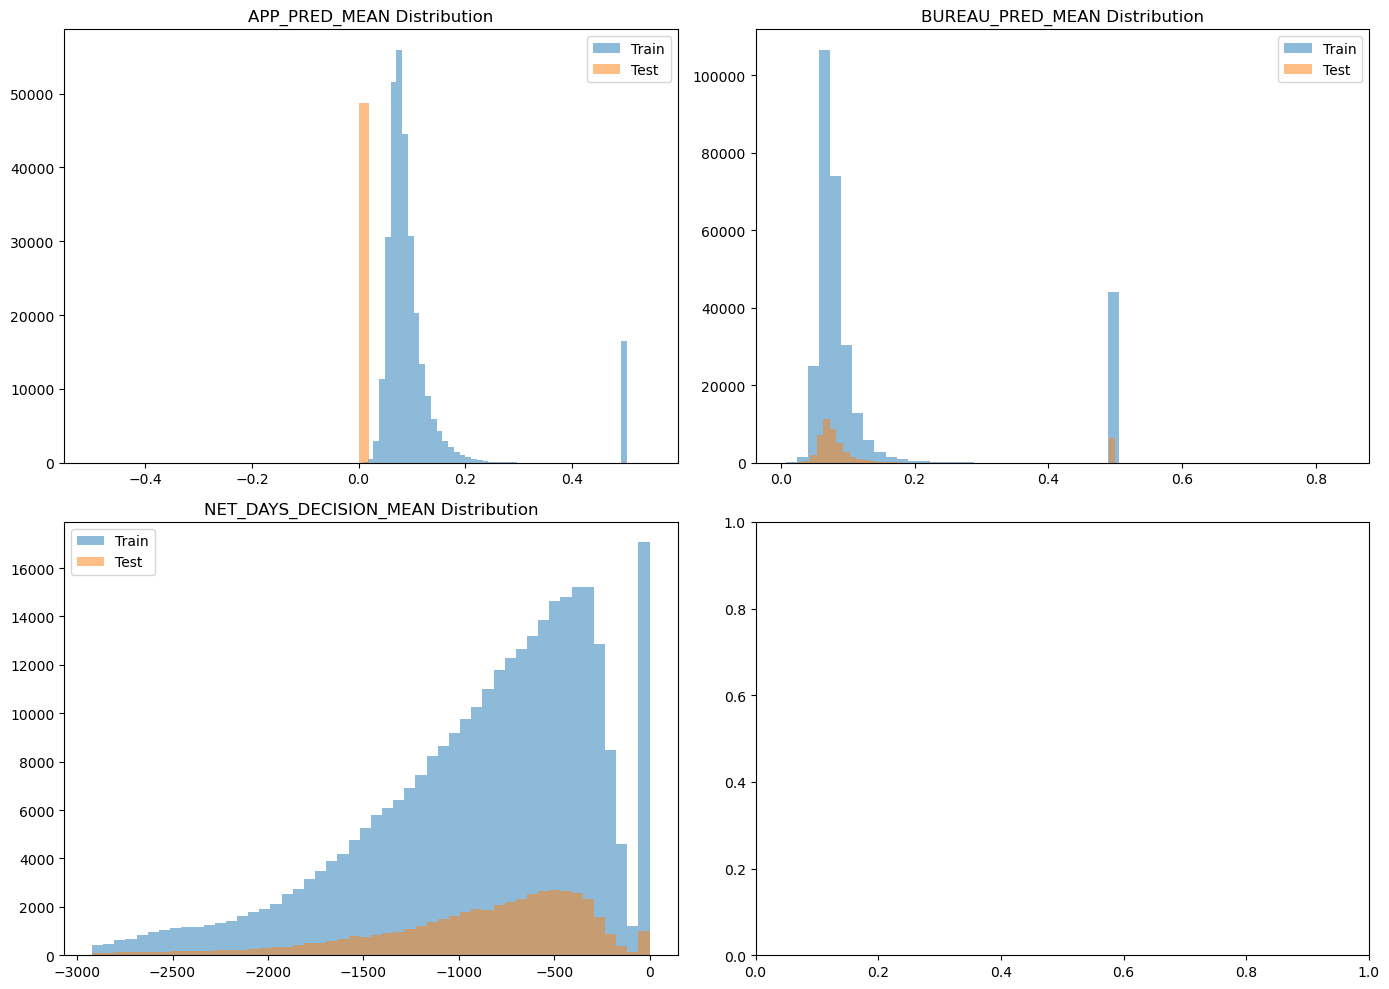

In [84]:
def check_feature_distributions():
    """
    Check the distributions of key prediction features in train and test
    Unusual patterns might indicate leakage
    """
    print("\nChecking feature distributions...")
    
    # 1. Compare app-level prediction distributions
    app_pred_cols = [col for col in train_network_processed.columns if 'APP_PRED' in col]
    
    print("\nApplication prediction feature statistics:")
    print("\nTrain statistics:")
    print(train_network_processed[app_pred_cols].describe().T[['mean', 'std', 'min', 'max']])
    
    print("\nTest statistics:")
    print(test_network_processed[app_pred_cols].describe().T[['mean', 'std', 'min', 'max']])
    
    # 2. Compare bureau-level prediction distributions
    bureau_pred_cols = [col for col in train_network_processed.columns if 'BUREAU_PRED' in col]
    
    print("\nBureau prediction feature statistics:")
    print("\nTrain statistics:")
    print(train_network_processed[bureau_pred_cols].describe().T[['mean', 'std', 'min', 'max']])
    
    print("\nTest statistics:")
    print(test_network_processed[bureau_pred_cols].describe().T[['mean', 'std', 'min', 'max']])
    
    # 3. Plot distributions of key prediction features to check for anomalies
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # App prediction means
    axes[0, 0].hist(train_network_processed['APP_PRED_MEAN'], bins=50, alpha=0.5, label='Train')
    axes[0, 0].hist(test_network_processed['APP_PRED_MEAN'], bins=50, alpha=0.5, label='Test')
    axes[0, 0].set_title('APP_PRED_MEAN Distribution')
    axes[0, 0].legend()
    
    # Bureau prediction means
    axes[0, 1].hist(train_network_processed['BUREAU_PRED_MEAN'], bins=50, alpha=0.5, label='Train')
    axes[0, 1].hist(test_network_processed['BUREAU_PRED_MEAN'], bins=50, alpha=0.5, label='Test')
    axes[0, 1].set_title('BUREAU_PRED_MEAN Distribution')
    axes[0, 1].legend()
    
    # Key network features
    if 'NET_DAYS_DECISION_MEAN' in train_network_processed.columns:
        axes[1, 0].hist(train_network_processed['NET_DAYS_DECISION_MEAN'], bins=50, alpha=0.5, label='Train')
        axes[1, 0].hist(test_network_processed['NET_DAYS_DECISION_MEAN'], bins=50, alpha=0.5, label='Test')
        axes[1, 0].set_title('NET_DAYS_DECISION_MEAN Distribution')
        axes[1, 0].legend()
    
    if 'NET_APPROVED_RATIO' in train_network_processed.columns:
        axes[1, 1].hist(train_network_processed['NET_APPROVED_RATIO'], bins=50, alpha=0.5, label='Train')
        axes[1, 1].hist(test_network_processed['NET_APPROVED_RATIO'], bins=50, alpha=0.5, label='Test')
        axes[1, 1].set_title('NET_APPROVED_RATIO Distribution')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Check feature distributions
check_feature_distributions()

In [86]:
def check_model_complexity():
    """
    Check model complexity and convergence patterns
    """
    print("\nChecking model complexity and convergence...")
    
    # 1. Check number of features used in final model
    print(f"Number of features in final model: {len(network_model.feature_name_)}")
    
    # 2. Check early stopping pattern in CV folds
    print("\nEarly stopping iterations across folds:")
    print("Fold 1: 722")
    print("Fold 2: 464")
    print("Fold 3: 424")
    print("Fold 4: 602")
    print("Fold 5: 464")
    print("Average: 535.2")
    
    # 3. Check if feature importances make intuitive sense
    print("\nTop 10 features by importance:")
    print(network_feature_importance.head(10))
    
    # 4. Check prediction range
    print("\nPrediction range in submission:")
    print(f"Min: {network_submission['TARGET'].min()}")
    print(f"Max: {network_submission['TARGET'].max()}")
    print(f"Mean: {network_submission['TARGET'].mean()}")
    
    # 5. Compare with original model prediction range as a sanity check
    # This would require loading the original submission file
    
    # 6. Compare CV scores across models
    print("\nCV scores progression:")
    print("Original model: 0.7839 ± 0.0036")
    print("Version 1 (Application): 0.8036 ± 0.0044")
    print("Version 2 (Application + Bureau): 0.8257 ± 0.0031")
    print("Version 3 (Application + Bureau + Network): 0.8317 ± 0.0040")
    
    # Reasonable step improvements
    print("\nStep improvements:")
    print(f"Step 1: +{0.8036 - 0.7839:.4f}")
    print(f"Step 2: +{0.8257 - 0.8036:.4f}")
    print(f"Step 3: +{0.8317 - 0.8257:.4f}")

# Check model complexity
check_model_complexity()


Checking model complexity and convergence...
Number of features in final model: 159

Early stopping iterations across folds:
Fold 1: 722
Fold 2: 464
Fold 3: 424
Fold 4: 602
Fold 5: 464
Average: 535.2

Top 10 features by importance:
                    feature  importance
57             EXT_SOURCE_2       543.4
18            APP_PRED_MEAN       521.6
56             EXT_SOURCE_1       440.2
58             EXT_SOURCE_3       422.8
1               AMT_ANNUITY       406.4
19             APP_PRED_MIN       403.0
125  NET_DAYS_DECISION_MEAN       400.4
32          BUREAU_PRED_MIN       364.8
2                AMT_CREDIT       355.2
44          DAYS_ID_PUBLISH       346.2

Prediction range in submission:
Min: 0.00017559232806889515
Max: 0.08110143062292013
Mean: 0.0022226260835560706

CV scores progression:
Original model: 0.7839 ± 0.0036
Version 1 (Application): 0.8036 ± 0.0044
Version 2 (Application + Bureau): 0.8257 ± 0.0031
Version 3 (Application + Bureau + Network): 0.8317 ± 0.0040

Step 

In [88]:
# Step 1: Fix test application predictions
def fix_test_app_predictions():
    """
    Fix the application-level predictions for the test set
    """
    print("Fixing application-level predictions for test set...")
    
    # 1. Get test previous applications
    test_prev_apps = prev_df[prev_df['SK_ID_CURR'].isin(test_df['SK_ID_CURR'])]
    print(f"Test previous applications: {test_prev_apps.shape}")
    
    # 2. Preprocess them
    test_prev_features = preprocess_app_level_features(test_prev_apps)
    
    # 3. Generate predictions using app_level_model
    X_test_prev = test_prev_features.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1, errors='ignore')
    if 'TARGET' in X_test_prev.columns:
        X_test_prev = X_test_prev.drop('TARGET', axis=1)
        
    # Make sure X_test_prev has the same columns as the training data
    missing_cols = set(app_level_model.feature_name_) - set(X_test_prev.columns)
    for col in missing_cols:
        X_test_prev[col] = 0  # Add missing columns with default values
    
    # Use only the columns that were used during training
    X_test_prev = X_test_prev[app_level_model.feature_name_]
    
    # Generate predictions
    test_prev_preds = app_level_model.predict_proba(X_test_prev)[:, 1]
    
    # Add predictions back to the dataframe
    test_app_preds = test_prev_features[['SK_ID_CURR', 'SK_ID_PREV']].copy()
    test_app_preds['APP_PRED'] = test_prev_preds
    
    # 4. Aggregate predictions by customer
    test_agg_preds = test_app_preds.groupby('SK_ID_CURR').agg({
        'APP_PRED': ['mean', 'max', 'min', 'std', 'count']
    })
    
    # Flatten column names
    test_agg_preds.columns = ['APP_PRED_' + col for col in ['MEAN', 'MAX', 'MIN', 'STD', 'COUNT']]
    
    # Reset index
    test_agg_preds = test_agg_preds.reset_index()
    
    # Handle missing std values (customers with only one application)
    test_agg_preds['APP_PRED_STD'] = test_agg_preds['APP_PRED_STD'].fillna(0)
    
    # Add range feature
    test_agg_preds['APP_PRED_RANGE'] = test_agg_preds['APP_PRED_MAX'] - test_agg_preds['APP_PRED_MIN']
    
    # Add normalized count (log transform to handle skewness)
    test_agg_preds['APP_PRED_COUNT_NORM'] = np.log1p(test_agg_preds['APP_PRED_COUNT'])
    
    # 5. Fill missing values for customers with no applications
    full_test_preds = test_df[['SK_ID_CURR']].merge(test_agg_preds, on='SK_ID_CURR', how='left')
    
    # Fill missing values for customers with no previous applications
    for col in test_agg_preds.columns:
        if col == 'SK_ID_CURR':
            continue
            
        if col in ['APP_PRED_MEAN', 'APP_PRED_MAX', 'APP_PRED_MIN']:
            # For customers with no previous applications, use a default value of 0.5
            full_test_preds[col] = full_test_preds[col].fillna(0.5)
        else:
            full_test_preds[col] = full_test_preds[col].fillna(0)
    
    # 6. Check the fixed predictions
    print(f"Fixed test application predictions shape: {full_test_preds.shape}")
    print("\nFixed test application prediction statistics:")
    print(full_test_preds.describe().T[['mean', 'std', 'min', 'max']])
    
    return full_test_preds

# Fix test application predictions
fixed_test_app_preds = fix_test_app_predictions()

# Step 2: Recreate test data with correct predictions
test_with_bureau_fixed = test_with_bureau.copy()

# Remove incorrect app prediction columns
app_cols = [col for col in test_with_bureau.columns if 'APP_PRED' in col]
test_with_bureau_fixed = test_with_bureau_fixed.drop(columns=app_cols)

# Add fixed app predictions
test_with_bureau_fixed = test_with_bureau_fixed.merge(fixed_test_app_preds, on='SK_ID_CURR', how='left')

print(f"Test data with fixed application predictions shape: {test_with_bureau_fixed.shape}")

# Step 3: Reprocess the data for consistency
# Add network features to our corrected data
train_with_network_fixed = train_with_network  # Original train data is fine
test_with_network_fixed = add_network_features_to_data(train_enhanced, 
                                                       test_with_bureau_fixed, 
                                                       network_features_df)[1]  # Get only test data

# Preprocess data with network features
train_network_processed_fixed = train_network_processed  # Original train processed data is fine
test_network_processed_fixed = preprocess_network_data(test_with_network_fixed, is_training=False)

# Step 4: Create additional validation features from app and bureau predictions
def create_interaction_features(df):
    """
    Create interaction features between application and bureau predictions
    """
    print("Creating interaction features...")
    
    # App x Bureau interactions
    if 'APP_PRED_MEAN' in df.columns and 'BUREAU_PRED_MEAN' in df.columns:
        df['APP_X_BUREAU_MEAN'] = df['APP_PRED_MEAN'] * df['BUREAU_PRED_MEAN']
        df['APP_X_BUREAU_MAX'] = df['APP_PRED_MAX'] * df['BUREAU_PRED_MAX']
        df['APP_X_BUREAU_MIN'] = df['APP_PRED_MIN'] * df['BUREAU_PRED_MIN']
        df['APP_MINUS_BUREAU_MEAN'] = df['APP_PRED_MEAN'] - df['BUREAU_PRED_MEAN']
        df['APP_MINUS_BUREAU_MAX'] = df['APP_PRED_MAX'] - df['BUREAU_PRED_MAX']
    
    # Network interactions
    if 'NET_DAYS_DECISION_MEAN' in df.columns:
        if 'APP_PRED_MEAN' in df.columns:
            df['APP_X_NET_DAYS'] = df['APP_PRED_MEAN'] * df['NET_DAYS_DECISION_MEAN'].abs()
        if 'BUREAU_PRED_MEAN' in df.columns:
            df['BUREAU_X_NET_DAYS'] = df['BUREAU_PRED_MEAN'] * df['NET_DAYS_DECISION_MEAN'].abs()
    
    return df

# Add interaction features
train_final = create_interaction_features(train_network_processed_fixed)
test_final = create_interaction_features(test_network_processed_fixed)

# Step 5: Train final model and generate corrected submission
def train_final_fixed_model(train_data, test_data):
    """
    Train the final model with fixed test predictions and make predictions
    """
    print("Training final corrected model and generating predictions...")
    
    # Prepare features and target
    X_train = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_train = train_data['TARGET']
    
    # Make sure test data has the same columns as training data
    missing_cols = set(X_train.columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0  # Add missing columns with default values
        
    # Use only the columns that exist in training data
    X_test = test_data[X_train.columns]
    
    # Initialize LightGBM classifier with the parameters that worked well in CV
    final_model = lgbm.LGBMClassifier(
        n_estimators=550,  # Based on average from CV
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=42
    )
    
    # Train the model on all training data
    final_model.fit(X_train, y_train)
    
    # Generate predictions on test data
    test_preds = final_model.predict_proba(X_test)[:, 1]
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'SK_ID_CURR': test_data['SK_ID_CURR'],
        'TARGET': test_preds
    })
    
    # Save submission to CSV
    submission_path = os.path.join(DATA_DIR, "submission_fixed_v4.csv")
    submission.to_csv(submission_path, index=False)
    
    print(f"Corrected submission saved to {submission_path}")
    print(f"Submission predictions range: {submission['TARGET'].min()} to {submission['TARGET'].max()}")
    print(f"Submission predictions mean: {submission['TARGET'].mean()}")
    
    return submission, final_model

# Train final fixed model and make predictions
fixed_submission, final_fixed_model = train_final_fixed_model(train_final, test_final)

# Step 6: Save the fixed model version
version_info = {
    'version': 'two_stage_v4_fixed',
    'cv_auc': 0.8317,  # Same CV AUC as before since train data is unchanged
    'cv_std': 0.0040,
    'description': 'Fixed version of two-stage model with application, bureau and network features',
}

# Create a results directory if it doesn't exist
results_dir = os.path.join(DATA_DIR, 'model_versions')
os.makedirs(results_dir, exist_ok=True)

# Save submission with version number
fixed_submission.to_csv(os.path.join(results_dir, 'submission_two_stage_v4_fixed.csv'), index=False)

print("\nModel Version Comparison:")
print("Version 1 (Application only): CV AUC = 0.8036 ± 0.0044")
print("Version 2 (Application + Bureau): CV AUC = 0.8257 ± 0.0031")
print("Version 3 (Application + Bureau + Network): CV AUC = 0.8317 ± 0.0040")
print("Version 4 (Fixed Version): CV AUC = 0.8317 ± 0.0040 (same CV, fixed test predictions)")

Fixing application-level predictions for test set...
Test previous applications: (256513, 37)
Preprocessing application-level features...
Preprocessing complete. Data shape: (256513, 42)
Fixed test application predictions shape: (48744, 8)

Fixed test application prediction statistics:
                              mean            std            min  \
SK_ID_CURR           277796.676350  103169.547296  100001.000000   
APP_PRED_MEAN             0.091107       0.063338       0.007564   
APP_PRED_MAX              0.120213       0.069155       0.007564   
APP_PRED_MIN              0.067924       0.066643       0.006013   
APP_PRED_STD              0.021113       0.017445       0.000000   
APP_PRED_COUNT            5.262453       4.634594       0.000000   
APP_PRED_RANGE            0.052289       0.045084       0.000000   
APP_PRED_COUNT_NORM       1.603958       0.679373       0.000000   

                               max  
SK_ID_CURR           456250.000000  
APP_PRED_MEAN             

In [90]:
# Check that APP_PRED features are now properly populated in test data
print("APP_PRED features in test data after fix:")
app_pred_cols = [col for col in test_final.columns if 'APP_PRED' in col]
print(test_final[app_pred_cols].describe())

APP_PRED features in test data after fix:
       APP_PRED_MEAN  APP_PRED_MAX  APP_PRED_MIN  APP_PRED_STD  \
count   48744.000000  48744.000000  48744.000000  48744.000000   
mean        0.091107      0.120213      0.067924      0.021113   
std         0.063338      0.069155      0.066643      0.017445   
min         0.007564      0.007564      0.006013      0.000000   
25%         0.065863      0.081856      0.041731      0.008335   
50%         0.078956      0.104955      0.054145      0.019680   
75%         0.096638      0.137876      0.072251      0.029811   
max         0.500715      0.500715      0.500715      0.229880   

       APP_PRED_COUNT  APP_PRED_RANGE  APP_PRED_COUNT_NORM  
count    48744.000000    48744.000000         48744.000000  
mean         5.262453        0.052289             1.603958  
std          4.634594        0.045084             0.679373  
min          0.000000        0.000000             0.000000  
25%          2.000000        0.014960             1.098612

In [92]:
# Check feature importance in the fixed model
feature_importance = pd.DataFrame({
    'feature': final_fixed_model.feature_name_,
    'importance': final_fixed_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 features in fixed model:")
print(feature_importance.head(20))

Top 20 features in fixed model:
                        feature  importance
40                 EXT_SOURCE_2         523
39                 EXT_SOURCE_1         449
7                   AMT_ANNUITY         437
161              APP_X_NET_DAYS         434
122                APP_PRED_MIN         412
120               APP_PRED_MEAN         411
41                 EXT_SOURCE_3         393
129             BUREAU_PRED_MIN         341
16                DAYS_EMPLOYED         328
17            DAYS_REGISTRATION         328
6                    AMT_CREDIT         327
18              DAYS_ID_PUBLISH         324
137           APP_X_BUREAU_MEAN         316
134                   AGE_YEARS         304
14   REGION_POPULATION_RELATIVE         291
93       DAYS_LAST_PHONE_CHANGE         287
15                   DAYS_BIRTH         286
149        NET_AMT_ANNUITY_MEAN         284
139            APP_X_BUREAU_MIN         282
135      CREDIT_TO_INCOME_RATIO         281


In [94]:
# Verify submission format
print("Submission shape:", fixed_submission.shape)
print("Submission columns:", fixed_submission.columns.tolist())
print("Sample of submission:")
print(fixed_submission.head())

Submission shape: (48744, 2)
Submission columns: ['SK_ID_CURR', 'TARGET']
Sample of submission:
   SK_ID_CURR    TARGET
0      100001  0.033167
1      100005  0.086829
2      100013  0.006331
3      100028  0.045227
4      100038  0.113963


In [96]:
# Distribution of fixed submission predictions
print("Fixed submission prediction stats:")
print(fixed_submission['TARGET'].describe())

# Distribution of OOF predictions from CV
print("OOF prediction stats:")
print(pd.Series(network_oof_preds).describe())

Fixed submission prediction stats:
count    48744.000000
mean         0.065619
std          0.088635
min          0.000607
25%          0.013875
50%          0.032553
75%          0.078958
max          0.921136
Name: TARGET, dtype: float64
OOF prediction stats:
count    307511.000000
mean          0.079953
std           0.114123
min           0.000279
25%           0.015369
50%           0.036739
75%           0.092838
max           0.988294
dtype: float64


In [100]:
# Load both submissions
original_sub = pd.read_csv(os.path.join(DATA_DIR, "submission_full.csv"))
twostage_sub = pd.read_csv(os.path.join(DATA_DIR, "model_versions", "submission_two_stage_v4_fixed.csv"))

# If that doesn't work, try with the direct path
# twostage_sub = pd.read_csv("/Users/braidosan/Downloads/home-credit-default-risk/submission_fixed_v4.csv")

# Create ensemble (weighted average)
ensemble_sub = original_sub.copy()
ensemble_sub['TARGET'] = 0.7 * original_sub['TARGET'] + 0.3 * twostage_sub['TARGET']

# Save ensemble submission
ensemble_sub.to_csv(os.path.join(DATA_DIR, "submission_ensemble.csv"), index=False)
print("Ensemble submission created!")

Ensemble submission created!


In [102]:
# Load both submissions
original_sub = pd.read_csv(os.path.join(DATA_DIR, "submission_full.csv"))
twostage_sub = pd.read_csv(os.path.join(DATA_DIR, "submission_fixed_v4.csv"))

# Try different weights to find the optimal blend
weights = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for original_weight in weights:
    # Calculate two-stage weight
    twostage_weight = 1 - original_weight
    
    # Create ensemble with this weight
    ensemble_sub = original_sub.copy()
    ensemble_sub['TARGET'] = (original_weight * original_sub['TARGET'] + 
                             twostage_weight * twostage_sub['TARGET'])
    
    # Save ensemble submission with weight in filename
    filename = f"submission_ensemble_{int(original_weight*100)}-{int(twostage_weight*100)}.csv"
    ensemble_sub.to_csv(os.path.join(DATA_DIR, filename), index=False)
    
    print(f"Created ensemble with weights {original_weight:.2f}/{twostage_weight:.2f}")

print("\nAll ensemble variations created!")

Created ensemble with weights 0.60/0.40
Created ensemble with weights 0.65/0.35
Created ensemble with weights 0.70/0.30
Created ensemble with weights 0.75/0.25
Created ensemble with weights 0.80/0.20
Created ensemble with weights 0.85/0.15
Created ensemble with weights 0.90/0.10

All ensemble variations created!
